# SNS Sentiment Analysis NN

Analyze social media texts and measure potential inflammatory / offensive language with a feedforward neural network.

In [1]:
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
import data_util as du
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

/Users/kalan/PycharmProjects/DS4400/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load Data

Load preprocessed data, vocabulary included. 

In [2]:
# Load dataset
train = pd.read_csv("./datasets/processed/train.csv")
X_train = train[train.columns[0]].apply(ast.literal_eval)
y_train = train[train.columns[1]].astype(int)
print(X_train.shape, y_train.shape)

test = pd.read_csv("./datasets/processed/test.csv")
X_test = test[test.columns[0]].apply(ast.literal_eval)
y_test = test[test.columns[1]].astype(int)
print(X_test.shape, y_test.shape)

# Load vocabulary
vocabulary = ast.literal_eval(open("./datasets/processed/vocabulary.txt", "r").read())
print("Vocabulary size:", len(vocabulary))

(8000,) (8000,)
(2000,) (2000,)
Vocabulary size: 11560


In [3]:
train_text = [" ".join(s) for s in X_train]
test_text = [" ".join(s) for s in X_test]
print("Lengths of train and test:", len(train_text), len(test_text))
print("train:test ratio:", len(train_text) / (len(train_text) + len(test_text)))
print("test:train ratio:", len(test_text) / (len(train_text) + len(test_text)))

Lengths of train and test: 8000 2000
train:test ratio: 0.8
test:train ratio: 0.2


# Vectorize data

In multinomial vectorization, we use it to calculate probabilities based on frequency of words from the vocabulary than whether the word has appeared at least once.

In [4]:
# Multinomial vectorizer, used to calculate probabilities based on vocabulary frequencies 
m_vectorizer = CountVectorizer(input='content', stop_words='english', binary=False, vocabulary=vocabulary, tokenizer=None, preprocessor=None)
X_train_m = m_vectorizer.fit_transform(train_text)
X_test_m = m_vectorizer.transform(test_text)

# Create a feedforward neural network then train it

Network has been tuned with different values for optimal results.

In [5]:
def create_ff_neural_network(X_training_data):
    model = Sequential([
        # Input layer
        # Input shape is also just vocabulary size
        Dense(units=256, input_dim=X_training_data.shape[1], activation='tanh'),
        Dropout(0.2),
        Dense(units=128, activation='tanh'),
        Dropout(0.2),
        Dense(units=64, activation='tanh'),
        Dropout(0.2),
        Dense(units=32, activation='tanh'),
        Dropout(0.2),
        # Output layer
        Dense(units=1, activation='sigmoid')
    ])
    
    # Legacy Adam
    opt = Adam(learning_rate=2e-5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
multinomial_model_ff = create_ff_neural_network(X_train_m)
multinomial_model_ff.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2959616   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

## Learning Rate Scheduler

If we have a high learning rate, we may unintentionally speed up convergence by making large updates. By reducing the learning rate, it helps the model fine-tune its weights allowing it to obtain a more accurate stance. This is made to prevent over-fitting with our large data.

In [7]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create a learning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
print("Multinomial Feedforward Neural Network:")

ff_history = multinomial_model_ff.fit(np.array(X_train_m.toarray()),
              np.array(y_train),
              epochs=10, batch_size=32,
              validation_data=(np.array(X_test_m.toarray()), np.array(y_test)),
              callbacks=[lr_callback])

Multinomial Feedforward Neural Network:
Epoch 1/10


2024-04-08 20:08:55.925207: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 2s 5ms/step - loss: 0.6756 - accuracy: 0.5789 - val_loss: 0.6532 - val_accuracy: 0.6745 - lr: 2.0000e-05
Epoch 2/10
250/250 [==============================] - 1s 4ms/step - loss: 0.6373 - accuracy: 0.6806 - val_loss: 0.6161 - val_accuracy: 0.7100 - lr: 2.0000e-05
Epoch 3/10
250/250 [==============================] - 1s 4ms/step - loss: 0.5923 - accuracy: 0.7253 - val_loss: 0.5780 - val_accuracy: 0.7325 - lr: 2.0000e-05
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.5438 - accuracy: 0.7514 - val_loss: 0.5482 - val_accuracy: 0.7350 - lr: 2.0000e-05
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.5016 - accuracy: 0.7739 - val_loss: 0.5313 - val_accuracy: 0.7390 - lr: 2.0000e-05
Epoch 6/10
250/250 [==============================] - 1s 4ms/step - loss: 0.4661 - accuracy: 0.7929 - val_loss: 0.5245 - val_accuracy: 0.7405 - lr: 1.8097e-05
Epoch 7/10
250/250 [==============================] - 1s 

In [10]:
# multinomial_model_ff.save('./models/sns_multinomial_ff.h5')
# multinomial_model_ff.save('./models/sns_multinomial_ff.keras')

In [11]:
# multinomial_model_ff = keras.models.load_model('./models/sns_multinomial.h5')

## Tuned Neural Network

In [30]:
def create_tuned_ffnn(hp: kt.HyperParameters):
    model = Sequential([
        # Input layer
        # Input shape is also just vocabulary size
        Dense(units=X_train_m.shape[1], input_dim=X_train_m.shape[1], activation='tanh'),
        Dropout(0.2),
        Dense(units=128, activation='tanh'),
        Dropout(0.2),
        Dense(units=64, activation='tanh'),
        Dropout(0.2),
        Dense(units=32, activation='tanh'),
        Dropout(0.2),
        # Output layer
        Dense(units=1, activation='sigmoid')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    # Legacy Adam
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [33]:
tuner = kt.RandomSearch(create_tuned_ffnn,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=1,
                     project_name='tuners',
                     directory='./')

Reloading Tuner from ./tuners/tuner0.json


In [34]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [36]:
tuner_history = tuner.search(np.array(X_train_m.toarray()), np.array(y_train), validation_data=(np.array(X_test_m.toarray()), np.array(y_test)), epochs=5, callbacks=[stop_early])

Trial 15 Complete [00h 05m 19s]
val_accuracy: 0.7444999814033508

Best val_accuracy So Far: 0.7444999814033508
Total elapsed time: 00h 32m 29s


In [37]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

In [38]:
best_nn = tuner.hypermodel.build(best_params)

In [39]:
best_nn_history = best_nn.fit(np.array(X_train_m.toarray()),
              np.array(y_train),
              epochs=10, batch_size=32,
              validation_data=(np.array(X_test_m.toarray()), np.array(y_test)),
              callbacks=[lr_callback])

Epoch 1/10
250/250 [==============================] - 44s 172ms/step - loss: 0.6397 - accuracy: 0.6639 - val_loss: 0.5932 - val_accuracy: 0.7330 - lr: 1.0000e-05
Epoch 2/10
250/250 [==============================] - 43s 169ms/step - loss: 0.5600 - accuracy: 0.7464 - val_loss: 0.5480 - val_accuracy: 0.7370 - lr: 1.0000e-05
Epoch 3/10
250/250 [==============================] - 41s 163ms/step - loss: 0.5032 - accuracy: 0.7781 - val_loss: 0.5252 - val_accuracy: 0.7410 - lr: 1.0000e-05
Epoch 4/10
250/250 [==============================] - 41s 163ms/step - loss: 0.4621 - accuracy: 0.7960 - val_loss: 0.5174 - val_accuracy: 0.7425 - lr: 1.0000e-05
Epoch 5/10
250/250 [==============================] - 40s 159ms/step - loss: 0.4257 - accuracy: 0.8179 - val_loss: 0.5205 - val_accuracy: 0.7415 - lr: 1.0000e-05
Epoch 6/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3971 - accuracy: 0.8313 - val_loss: 0.5291 - val_accuracy: 0.7390 - lr: 9.0484e-06
Epoch 7/10
250/250 [========

In [ ]:
best_nn.save('./models/sns_tuned_nn.h5')
best_nn.save_weights('./models/sns_tuned_nn.weights.h5')

# Make predictions

In [40]:
def probs_to_preds(probabilities: list) -> list[int]:
    """
    Converts continuous (sigmoid) outputs to discrete binary probabilities
    :param probabilities: List of probabilities between [0, 1]
    :return: 
    """
    return [1 if p[0] > 0.5 else 0 for p in probabilities]

In [15]:
raw_predictions_ff = multinomial_model_ff.predict(X_test_m.toarray())
preds_ff = probs_to_preds(raw_predictions_ff)

63/63 [==============================] - 0s 2ms/step


In [41]:
raw_predictions_best_nn = best_nn.predict(X_test_m.toarray())
preds_best_nn = probs_to_preds(raw_predictions_best_nn)

63/63 [==============================] - 1s 14ms/step


In [16]:
_, _, _, _ = du.get_prfa(y_test, preds_ff, verbose=True)

Precision: 0.718139534883721
Recall: 0.7774420946626385
F1 Score: 0.746615087040619
Accuracy: 0.738


In [43]:
_ = du.get_prfa(y_test, preds_best_nn, verbose=True)

Precision: 0.71939736346516
Recall: 0.7693856998992951
F1 Score: 0.743552311435523
Accuracy: 0.7365


In [45]:
def predict_inflammatory_level(model: Sequential, text):
    # Vectorize the input text
    X_input = m_vectorizer.transform([text])
    
    # Get the prediction from the trained model
    prediction = model.predict(X_input.toarray())
    
    # The output is a probability value between 0 and 1
    inflammatory_level = prediction[0][0]
    
    return inflammatory_level

In [18]:
# Example of predicting inflammatory text with a probability
print(predict_inflammatory_level(multinomial_model_ff, "test text"))

1/1 [==============================] - 0s 13ms/step
0.23211204


In [49]:
print(predict_inflammatory_level(best_nn, "test text, very passive"))

1/1 [==============================] - 0s 12ms/step
0.19137672


# Plot history

<Figure size 500x800 with 0 Axes>

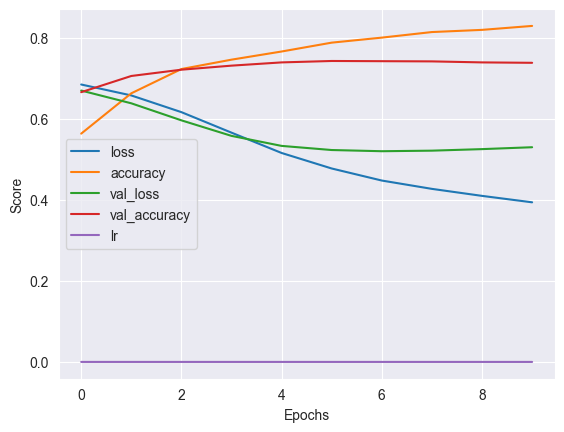

In [271]:
plt.figure(figsize=(5, 8))
pd.DataFrame(ff_history.history).plot()
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.savefig('./graphs/ff_history_2.png')
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 500x800 with 0 Axes>

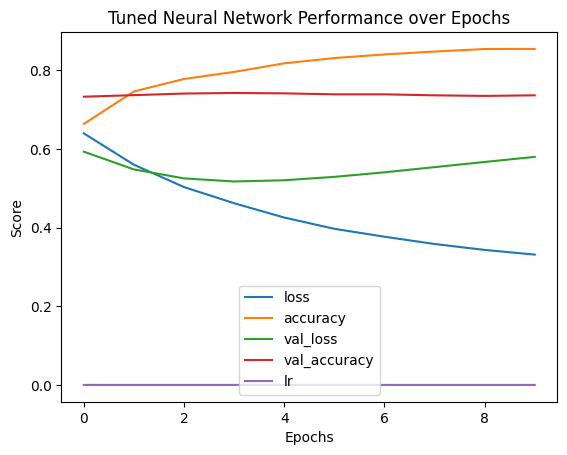

In [53]:
plt.clf()
plt.figure(figsize=(5, 8))
pd.DataFrame(best_nn_history.history).plot()
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Tuned Neural Network Performance over Epochs")
plt.savefig('./graphs/best_nn_history.png')
plt.show()